In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim


In [3]:
# Load data
X_male = np.load("Unify_Gait_Cycles/X_male.npy")
X_female = np.load("Unify_Gait_Cycles/X_female.npy")
label_male = [0]*X_male.shape[0]
label_female = [1]*X_female.shape[0]

gait_cycles = np.append(X_male, X_female, axis=0)
labels = np.append(label_male, label_female, axis = 0)

print(gait_cycles.shape)
print(labels.shape)

(9968, 100, 4)
(9968,)


In [4]:
# Shuffle the data
perm = np.random.permutation(gait_cycles.shape[0])
gait_cycles = gait_cycles[perm]
labels = labels[perm]




In [68]:
gait_cycles_train = gait_cycles[0:-500]
gait_cycles_test = gait_cycles[-500:]

labels_train = labels[0:-500]
labels_test = labels[-500:]
# Make them nice tensors :)
batch_size = 9
# gait_cycles_train = torch.FloatTensor(gait_cycles_train[:,:,3]).reshape(-1,batch_size,1,100)
# gait_cycles_test = torch.FloatTensor(gait_cycles_test[:,:,3]).reshape(-1,1,1,100)
# labels_train = torch.LongTensor(labels_train).reshape(-1,batch_size)
# labels_test = torch.LongTensor(labels_test).reshape(-1, 1)
gait_cycles_train = torch.FloatTensor(gait_cycles_train).permute(0,2,1).reshape(-1,batch_size,4,100)
gait_cycles_test = torch.FloatTensor(gait_cycles_test).permute(0,2,1).reshape(-1,1,4,100)
labels_train = torch.LongTensor(labels_train).reshape(-1,batch_size)
labels_test = torch.LongTensor(labels_test).reshape(-1, 1)

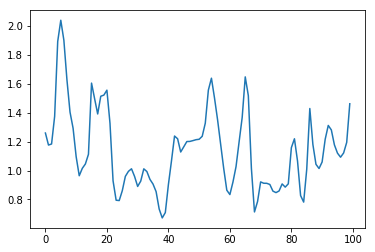

torch.Size([1052, 9, 4, 100])


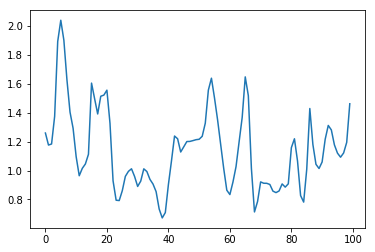

In [69]:
# Visualize the data
one_person = gait_cycles[0]
t = range(one_person.shape[0])
mag = one_person[:,3]
plt.plot(t,mag)
plt.show()
print(gait_cycles_train.shape)
one_person2 = gait_cycles_train[0,0,3,:].numpy()
t = range(100)
plt.figure()
plt.plot(t, one_person2)
plt.show()

In [70]:
class Flatten(nn.Module):
    
    def forward(self, input):
        return input.view(input.size(0), -1)

In [71]:
class Gait_Classifier(nn.Module):
    """
    TODO: Add attention
    """
    def __init__(self, input_size=100, kernel_size=10, hidden_size=500):
        super(Gait_Classifier, self).__init__()
        
        self.layers = nn.ModuleList()
       # self.layers.append(nn.Conv1d(1, 20, kernel_size))
        self.layers.append(nn.Sequential(
            nn.Conv1d(4, 20, kernel_size),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)))
        self.layers.append(nn.Sequential(
            nn.Conv1d(20, 40, kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)))
        self.layers.append(nn.Dropout(0.1))
        self.layers.append(Flatten())
        self.layers.append(nn.Linear(20*18, hidden_size))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(hidden_size, 2))
        self.layers.append(nn.Softmax(dim=1))
        
        
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

    

In [72]:
#https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/ Helped a lot!

def train_model(model, optimizer, x_train, y_train, x_test, y_test, batch_size, num_epochs=20):
    loss_list = []
    acc_list = []
    total_step = len(x_train)
    criterion = nn.CrossEntropyLoss()
    
    correct = 0.0
    model = model.eval()
    validation_loss = 0
    for (test_gait, test_lab) in zip(x_test, y_test):
        prediction = model(test_gait)
        validation_loss += criterion(prediction, test_lab)
        if prediction.argmax() == test_lab:
            correct += 1.0
    acc = correct / y_test.size()[0]
    acc_list.append(acc)
    validation_loss /= x_test.shape[0]
    loss_list.append(validation_loss)
    model = model.train()
    
    for epoch in range(num_epochs):
        for i, (gaits, labels) in enumerate(zip(x_train, y_train)):
            # Run the forward pass
            outputs = model(gaits)
            loss = criterion(outputs, labels)
            #loss_list.append(loss.item())

            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            # acc_list.append(correct / total)
            
            if (i + 1) % 1000 == 0:
                correct = 0.0
                model = model.eval()
                validation_loss = 0
                for (test_gait, test_lab) in zip(x_test, y_test):
                    prediction = model(test_gait)
                    validation_loss += criterion(prediction, test_lab)
                    if prediction.argmax() == test_lab:
                        correct += 1.0
                acc = correct / y_test.size()[0]
                acc_list.append(acc)
                validation_loss /= x_test.shape[0]
                loss_list.append(validation_loss)
                model = model.train()
                    
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, validation_loss,
                              acc * 100))
        
    correct = 0.0
    model = model.eval()
    validation_loss = 0
    for (test_gait, test_lab) in zip(x_test, y_test):
        prediction = model(test_gait)
        validation_loss += criterion(prediction, test_lab)
        if prediction.argmax() == test_lab:
            correct += 1.0
    acc = correct / y_test.size()[0]
    acc_list.append(acc)
    validation_loss /= x_test.shape[0]
    loss_list.append(validation_loss)
    model = model.train()
    return loss_list, acc_list
            

In [73]:
gc = Gait_Classifier()
learning_rate = 3e-5
optimizer = torch.optim.Adam(gc.parameters(), lr=learning_rate)
(loss, acc) = train_model(gc, optimizer, gait_cycles_train, labels_train, gait_cycles_test, labels_test, 1)


Epoch [1/20], Step [1000/1052], Loss: 0.5931, Accuracy: 70.20%
Epoch [2/20], Step [1000/1052], Loss: 0.5500, Accuracy: 77.00%
Epoch [3/20], Step [1000/1052], Loss: 0.5248, Accuracy: 80.80%
Epoch [4/20], Step [1000/1052], Loss: 0.5087, Accuracy: 80.60%
Epoch [5/20], Step [1000/1052], Loss: 0.4992, Accuracy: 81.00%
Epoch [6/20], Step [1000/1052], Loss: 0.4933, Accuracy: 81.20%
Epoch [7/20], Step [1000/1052], Loss: 0.4892, Accuracy: 81.60%
Epoch [8/20], Step [1000/1052], Loss: 0.4858, Accuracy: 81.40%
Epoch [9/20], Step [1000/1052], Loss: 0.4834, Accuracy: 81.40%
Epoch [10/20], Step [1000/1052], Loss: 0.4804, Accuracy: 82.40%
Epoch [11/20], Step [1000/1052], Loss: 0.4801, Accuracy: 82.00%
Epoch [12/20], Step [1000/1052], Loss: 0.4782, Accuracy: 82.60%
Epoch [13/20], Step [1000/1052], Loss: 0.4771, Accuracy: 83.00%
Epoch [14/20], Step [1000/1052], Loss: 0.4766, Accuracy: 82.80%
Epoch [15/20], Step [1000/1052], Loss: 0.4744, Accuracy: 83.20%
Epoch [16/20], Step [1000/1052], Loss: 0.4744, Ac

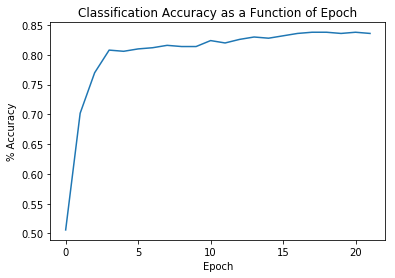

In [74]:
plt.plot(range(len(acc)),acc)
plt.title('Classification Accuracy as a Function of Epoch')
plt.ylabel('% Accuracy')
plt.xlabel("Epoch")
#plt.savefig("classification_accuracy_Test.png")
plt.show()

In [76]:
(loss, acc) = train_model(gc, optimizer, gait_cycles_train, labels_train, gait_cycles_test, labels_test, 1, num_epochs=20)





Epoch [1/20], Step [1000/1052], Loss: 0.4509, Accuracy: 85.20%
Epoch [2/20], Step [1000/1052], Loss: 0.4556, Accuracy: 85.60%
Epoch [3/20], Step [1000/1052], Loss: 0.4540, Accuracy: 85.00%
Epoch [4/20], Step [1000/1052], Loss: 0.4472, Accuracy: 86.00%
Epoch [5/20], Step [1000/1052], Loss: 0.4503, Accuracy: 85.60%
Epoch [6/20], Step [1000/1052], Loss: 0.4495, Accuracy: 86.00%
Epoch [7/20], Step [1000/1052], Loss: 0.4499, Accuracy: 86.00%
Epoch [8/20], Step [1000/1052], Loss: 0.4505, Accuracy: 86.20%
Epoch [9/20], Step [1000/1052], Loss: 0.4519, Accuracy: 85.80%
Epoch [10/20], Step [1000/1052], Loss: 0.4493, Accuracy: 85.20%
Epoch [11/20], Step [1000/1052], Loss: 0.4483, Accuracy: 86.00%
Epoch [12/20], Step [1000/1052], Loss: 0.4502, Accuracy: 86.00%
Epoch [13/20], Step [1000/1052], Loss: 0.4490, Accuracy: 86.40%
Epoch [14/20], Step [1000/1052], Loss: 0.4487, Accuracy: 86.20%
Epoch [15/20], Step [1000/1052], Loss: 0.4500, Accuracy: 85.80%
Epoch [16/20], Step [1000/1052], Loss: 0.4476, Ac

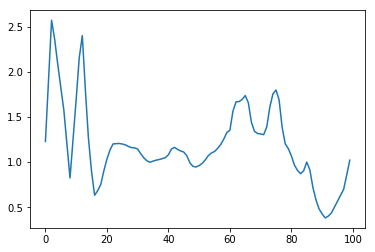

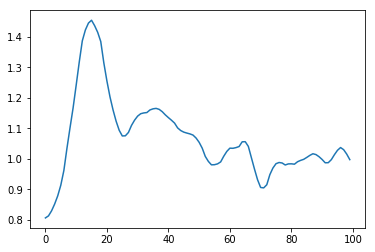

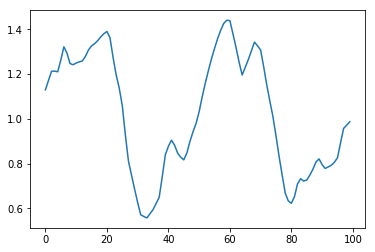

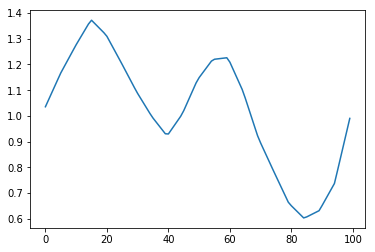

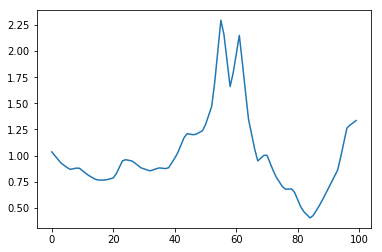

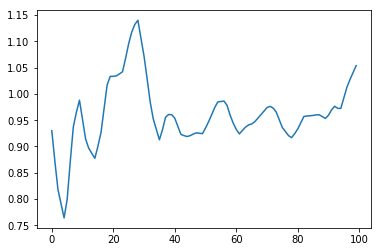

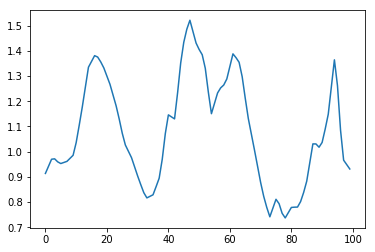

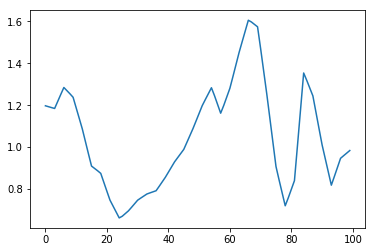

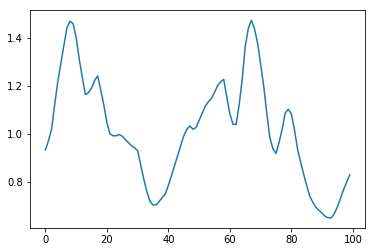

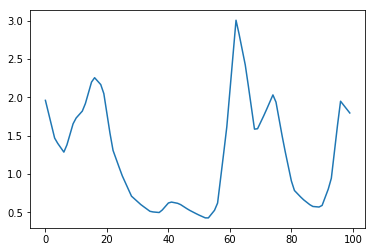

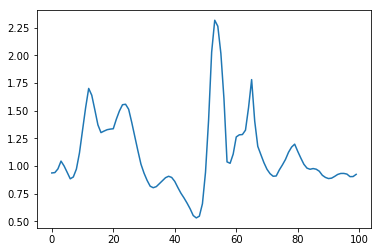

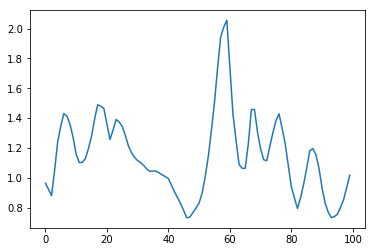

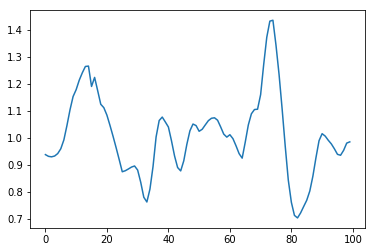

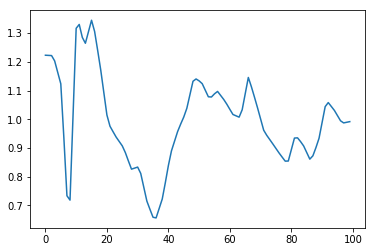

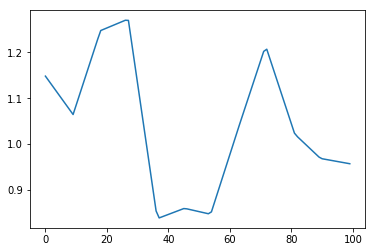

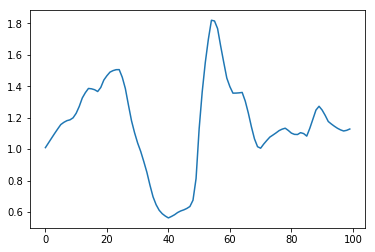

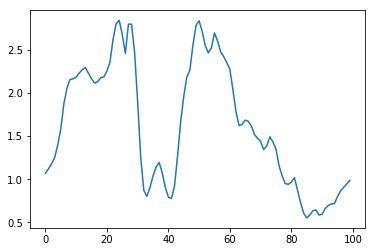

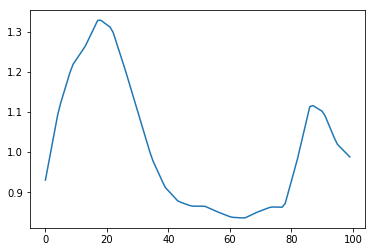

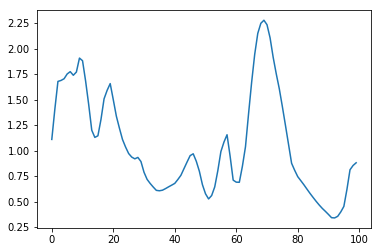

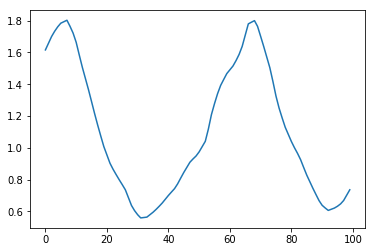

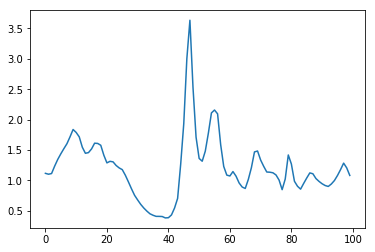

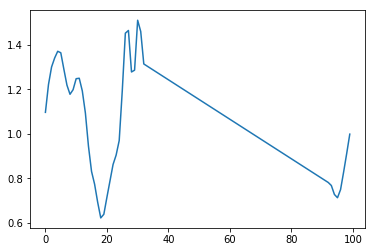

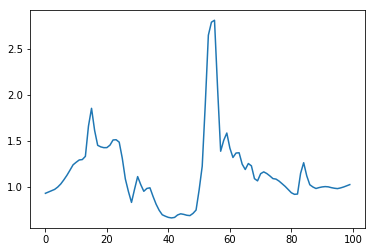

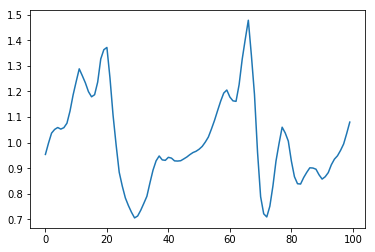

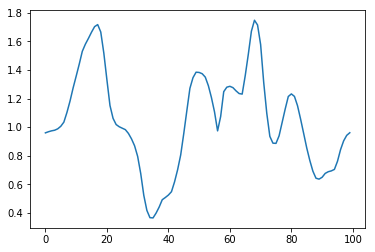

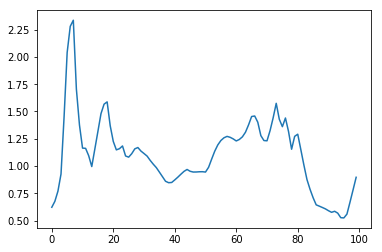

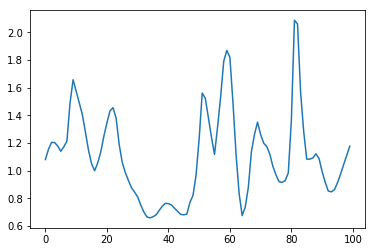

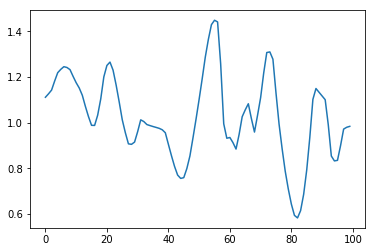

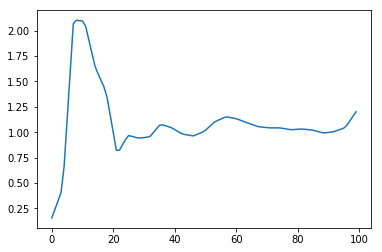

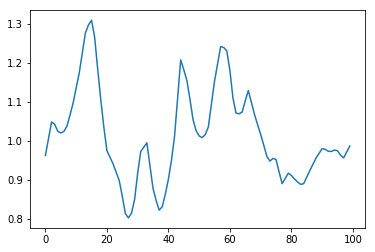

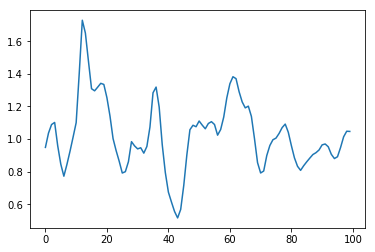

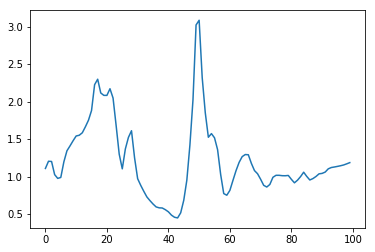

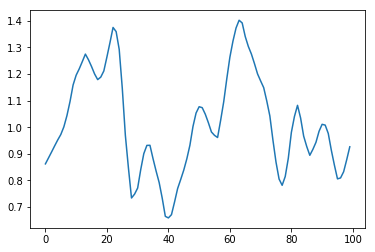

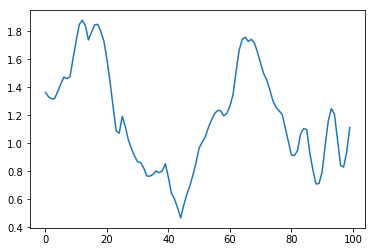

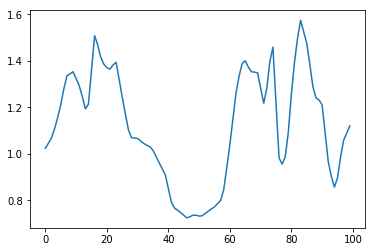

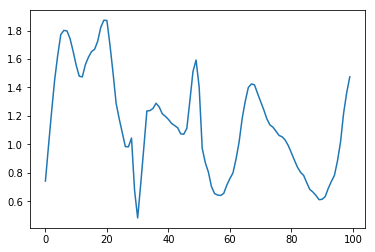

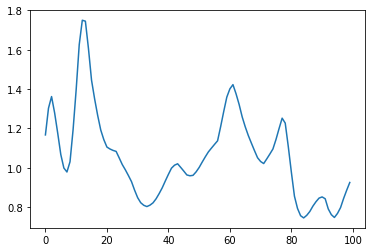

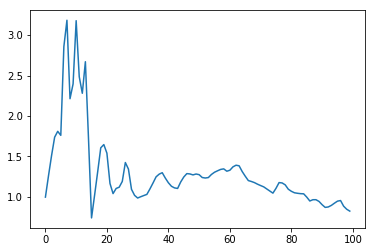

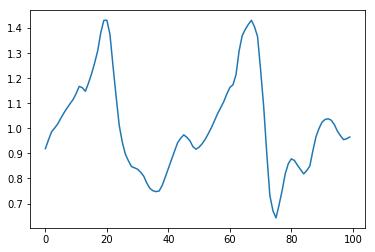

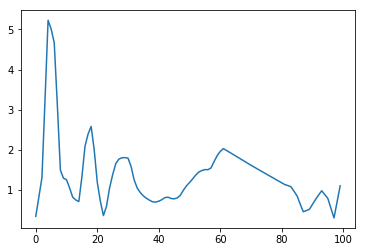

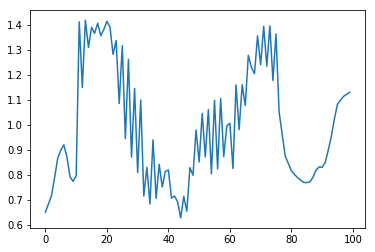

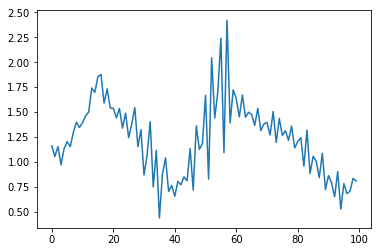

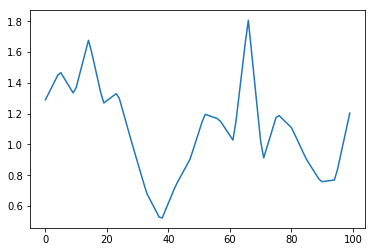

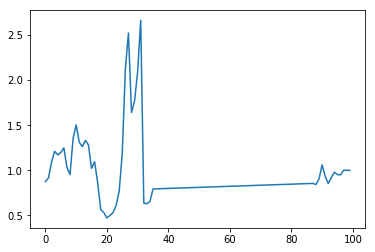

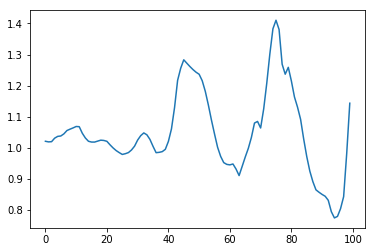

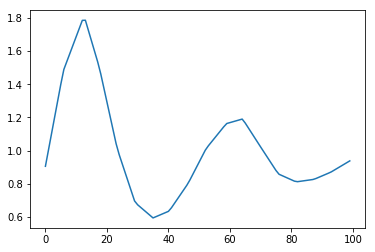

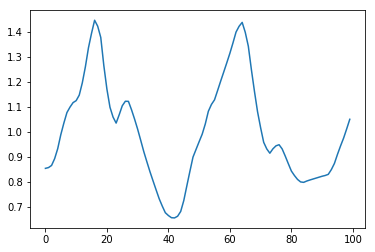

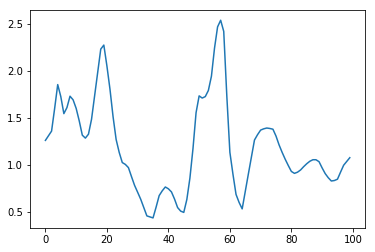

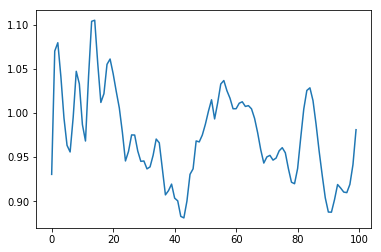

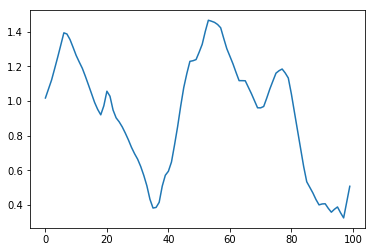

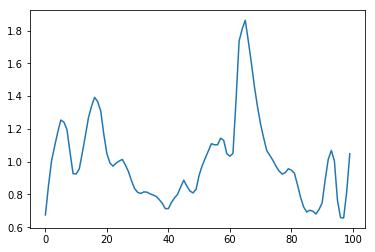

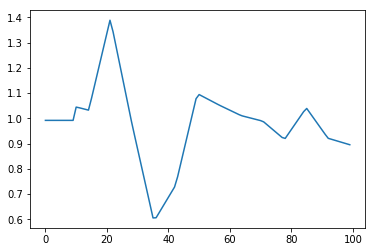

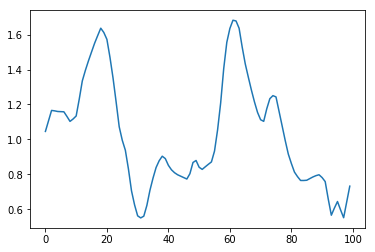

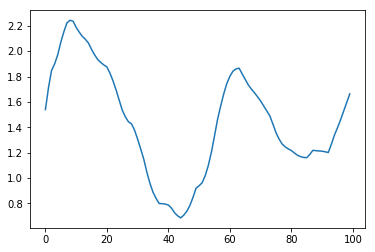

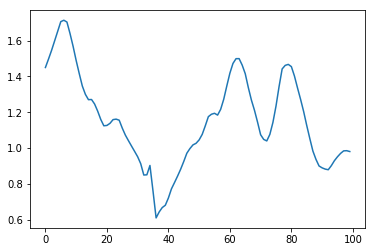

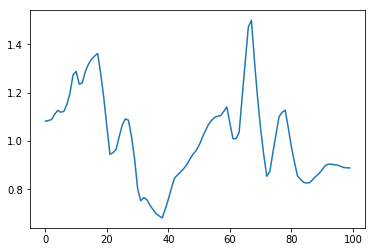

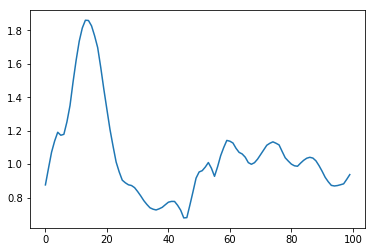

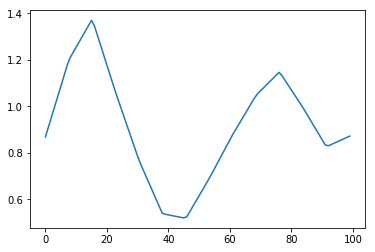

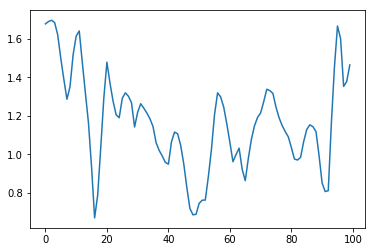

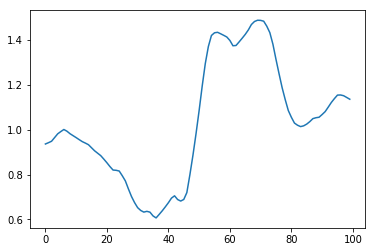

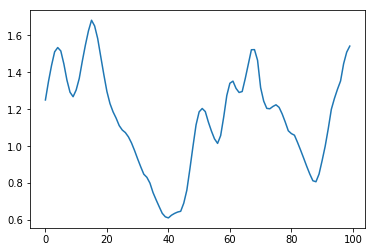

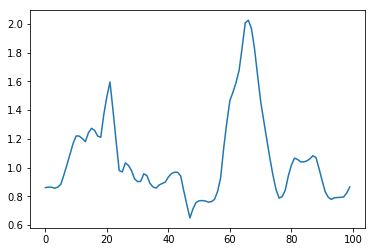

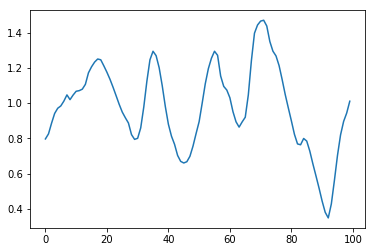

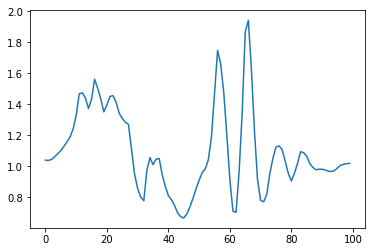

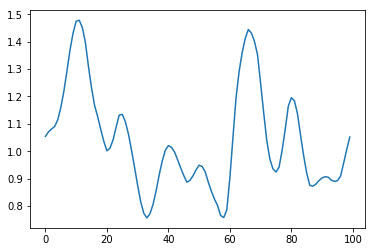

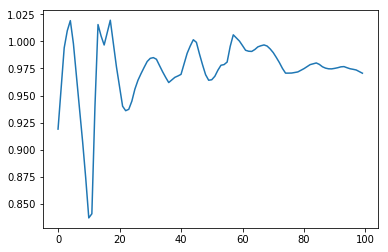

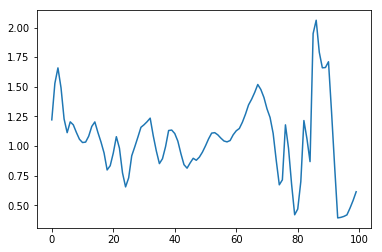

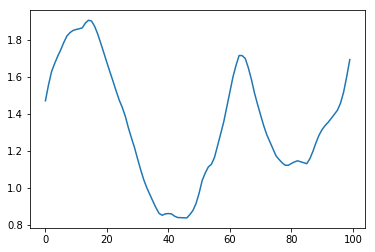

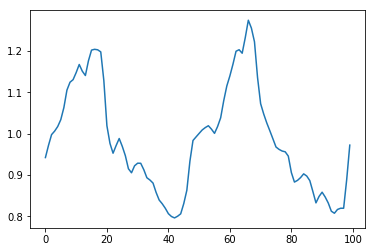

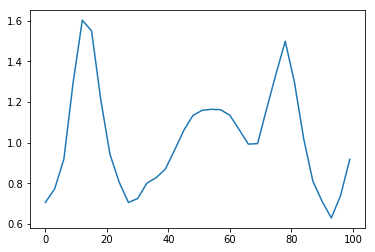

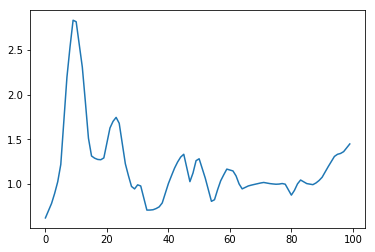

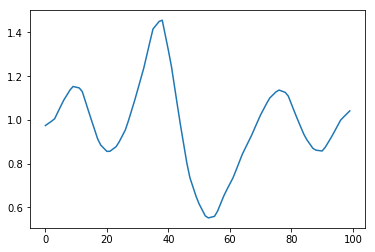

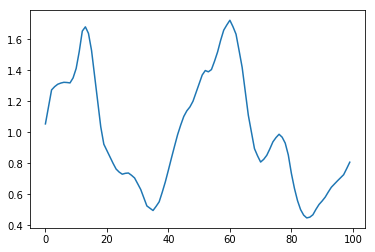

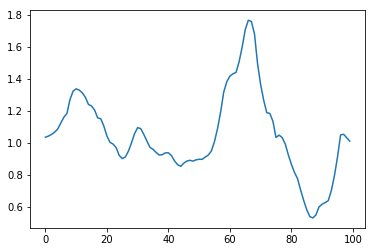

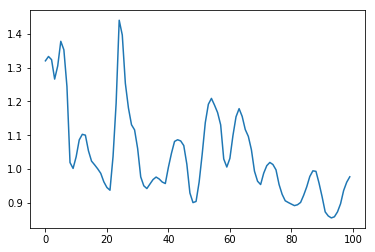

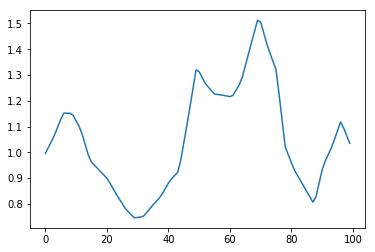

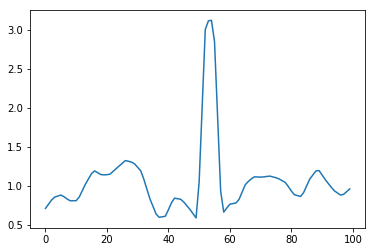

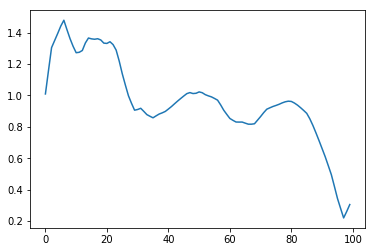

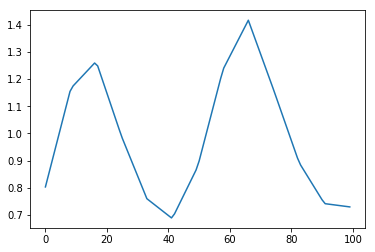

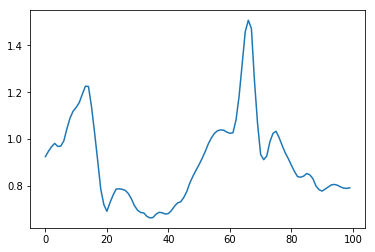

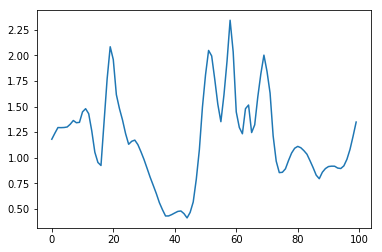

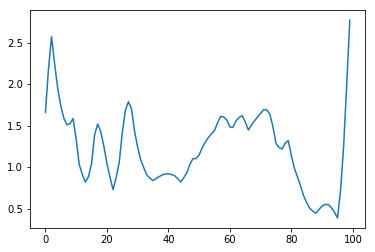

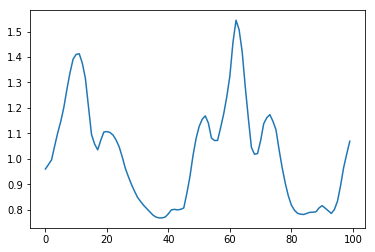

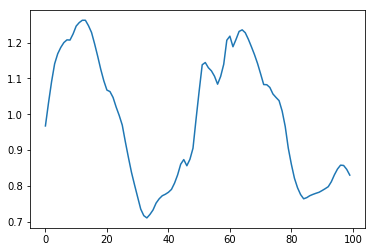

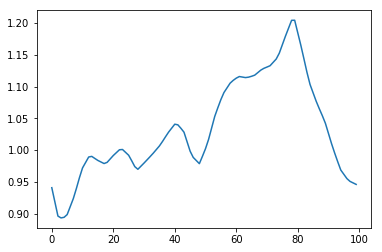

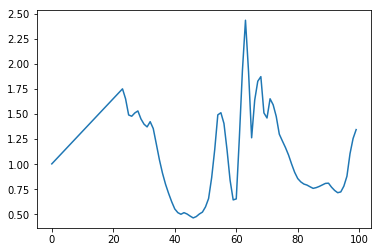

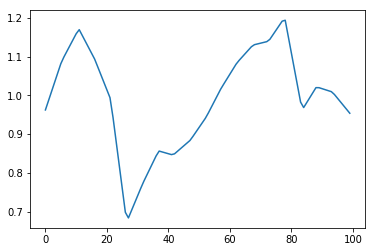

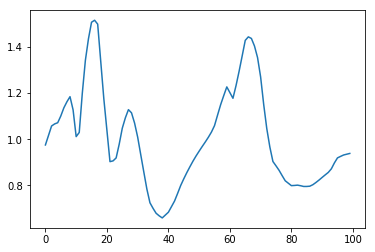

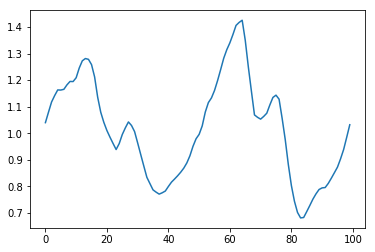

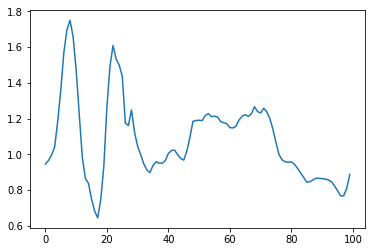

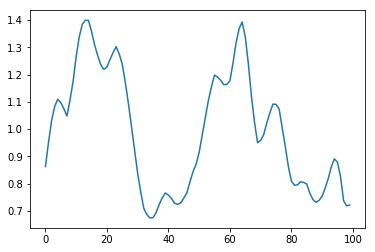

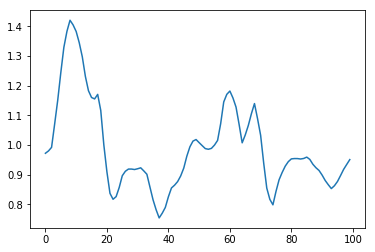

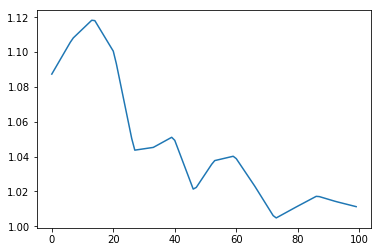

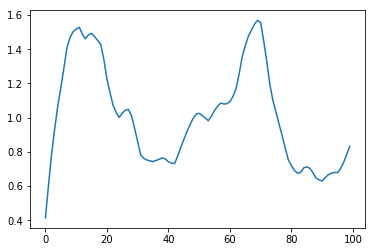

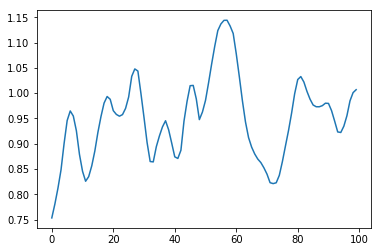

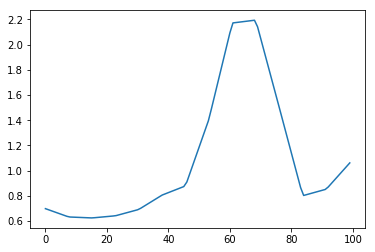

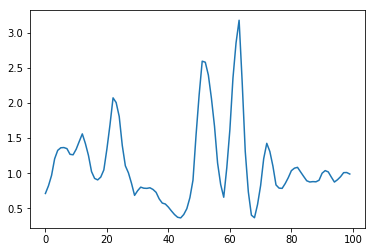

In [49]:
wrong_indices = []
for i in range(len(labels_test)):
    if gc(gait_cycles_test[i]).argmax() != labels_test[i]:
        wrong_indices.append(i)

gait_cycles_numpy = gait_cycles[-500:]
for i in wrong_indices:
    one_person = gait_cycles_numpy[i]
    t = range(one_person.shape[0])
    mag = one_person[:,3]
    plt.plot(t,mag)
    plt.show()

In [13]:
print(labels_test[i])

tensor([0])
